In [1]:
# modules to import 

import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
import math

# Turn off TensorFlow warning messages in program output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [38]:
Y_validation.shape

(1412, 1)

In [39]:
training_data_df = pd.read_csv("./trnDataNDcell.csv")
validation_data_df = pd.read_csv("./valDataNDcell.csv")
testing_data_df = pd.read_csv("./tstDataNDcell.csv")

In [40]:
Y_train = training_data_df[['ct']].values  # (4943, 1)
Features_train = training_data_df.drop('ct', axis=1).values

Y_validation = validation_data_df[['ct']].values # (1412, 1)
Features_validation = validation_data_df.drop('ct', axis=1).values

Y_test = testing_data_df[['ct']].values  # (706, 1)
Features_test = testing_data_df.drop('ct', axis=1).values

In [42]:
## ==================================
## Example for using one-hot-encoder
## ==================================
values = np.array([['A', 'A', 'B', 'C', 'A', 'B', 'C']]).transpose()
print(values)
print(values.shape)

# help(OneHotEncoder)

# Creat the encoder once
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(values)

# Use the encoder multiple times
Labels_1 = enc.transform(values)
print(Labels_1)

values2 = np.array([['A', 'A', 'C', 'D']]).transpose() # 2nd set of values
Labels_2 = enc.transform(values2) # transform directly 
print(Labels_2)


[['A']
 ['A']
 ['B']
 ['C']
 ['A']
 ['B']
 ['C']]
(7, 1)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [43]:
# help(OneHotEncoder)

In [44]:
# Use training labels to creat the encoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(Y_train)

# Use the encoder to transform all labels
Labels_train = enc.transform(Y_train)
print("Train: ", Labels_train.shape)

Labels_validation = enc.transform(Y_validation) # transform directly 
print("Validation: ", Labels_validation.shape)

Labels_test = enc.transform(Y_test) # transform directly
print("Test: ", Labels_test.shape)

print(enc.get_feature_names())  # to get categories in encoding order
print(Y_train[5:10, :])
print(Labels_train[5:10, :])

Train:  (4943, 9)
Validation:  (1412, 9)
Test:  (706, 9)
['x0_Cortex' 'x0_Endodermis' 'x0_Hair Cells' 'x0_Meristem'
 'x0_Non Hair Cells' 'x0_Phloem' 'x0_Root Cap Cells' 'x0_Stele' 'x0_Xylem']
[['Stele']
 ['Stele']
 ['Root Cap Cells']
 ['Hair Cells']
 ['Phloem']]
[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [45]:
# Define model parameters

momentum = 0
decay = 0.9
learning_rate = 0.005
training_epochs = 5000
batch_size = 900
display_step = 1  ## can change that to display less steps
num_examples = Labels_train.shape[0]

# Define how many inputs and outputs are in our neural network
number_of_inputs = Features_train.shape[1]
number_of_outputs = Labels_train.shape[1]
print("Number of inputs = ", number_of_inputs)

# Define how many neurons we want in each layer of our neural network
layer_1_nodes = number_of_inputs
layer_2_nodes = 1500
layer_3_nodes = 500
layer_4_nodes = 100 # number_of_outputs*2

Number of inputs =  3000


In [46]:
## Function to construct a layer --
def layer(input, weight_shape, bias_shape ):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [47]:
## Inference: Produce a probability dist over the output classes given a minibatch
def inference(x):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x, [number_of_inputs, layer_1_nodes], [layer_1_nodes])
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [layer_1_nodes, layer_2_nodes], [layer_2_nodes])
    with tf.variable_scope("hidden_3"):
        hidden_3 = layer(hidden_2, [layer_2_nodes, layer_3_nodes], [layer_3_nodes])
    with tf.variable_scope("hidden_4"):
        hidden_4 = layer(hidden_3, [layer_3_nodes, layer_4_nodes], [layer_4_nodes])
    with tf.variable_scope("output"):
        output = layer(hidden_4, [layer_4_nodes, number_of_outputs], [number_of_outputs])
    return output

In [48]:
## Get cross-entopy loss given correct labels of a minibatch
def loss(output, y):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)
    return loss

In [49]:
## Training: responsible for computing the gradients of the model parameters
## and updating the model. We use built-in optimizers that produce a training operation
## that we can run via a tf session to minimize model parameters.
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay, momentum, epsilon=1e-10, use_locking=False, name='RMSProp')
    #optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op


In [50]:
## Simple computational subgraph to evaluate the model on the validation or test set
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [51]:
def evaluate_pc(output, y):
    acc, acc_op = tf.metrics.mean_per_class_accuracy(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1), num_classes = number_of_outputs)
    return (acc, acc_op)


In [52]:
def get_conf_mat(output, y):
    conf_mat = tf.confusion_matrix(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1))
    return conf_mat

In [53]:
accuracies = []

In [54]:
# Run TensorFlow --
with tf.Graph().as_default():
    # Input data with 'number_of_inputs' variables
    x = tf.placeholder("float", [None, number_of_inputs])
    # Output classes
    y = tf.placeholder("float", [None, number_of_outputs])
    output = inference(x)
    cost = loss(output, y)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = training(cost, global_step)
    eval_op = evaluate(output, y)
    evalpc_op = evaluate_pc(output, y)
    get_conf_mat_op = get_conf_mat(output, y)
    
    # Collect all summary statistics that have been logged
    summary_op = tf.summary.merge_all()
    # Save the model parameters using train.Saver() that keeps the latest 5
    # check points, which can be restored for future use
    saver = tf.train.Saver()
    sess = tf.Session()
    
    # write summary statistics to disk
    summary_writer = tf.summary.FileWriter("logs/", graph=sess.graph)
    
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    sess.run(tf.local_variables_initializer())
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(num_examples/batch_size)
        # Loop over all batches
        shuffle_vec = np.random.permutation(num_examples)
        Features_train = Features_train[shuffle_vec]
        Labels_train = Labels_train[shuffle_vec]
        for i in range(total_batch):
            mbfrom, mbto = ((i-1)*batch_size, i*batch_size)
            mbatch_x, mbatch_y = (Features_train[mbfrom:mbto, :], Labels_train[mbfrom:mbto, :])
            # Fit training using batch data
            feed_dict = {x: mbatch_x, y: mbatch_y}
            sess.run(train_op, feed_dict=feed_dict)
            # Compute average loss
            minibatch_cost = sess.run(cost, feed_dict=feed_dict)
            avg_cost += minibatch_cost/total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_feed_dict = {x: Features_validation[:,:], y: Labels_validation[:,:]}
            accuracy = sess.run(eval_op, feed_dict=val_feed_dict)
            print("Epoch: ", epoch)
            print("Validation Error:", (1 - accuracy))
            print("Accuracy:", accuracy)
            accuracies.append(accuracy)
            summary_str = sess.run(summary_op, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, sess.run(global_step))
            saver.save(sess, "logs/model-checkpoint", global_step=global_step)
    print("Optimization Finished!")
    test_feed_dict = {x: Features_test[:,:], y: Labels_test[:,:]}
    accuracy = sess.run(eval_op, feed_dict=test_feed_dict)
    print("Test Accuarcy:", accuracy)
    acc, acc_op = sess.run(evalpc_op, feed_dict=test_feed_dict)
    print([acc, acc_op])
    cm = sess.run(get_conf_mat_op, feed_dict=test_feed_dict)
    print(cm)


Epoch:  0
Validation Error: 0.3611897826194763
Accuracy: 0.6388102
Epoch:  1
Validation Error: 0.2259206771850586
Accuracy: 0.7740793
Epoch:  2
Validation Error: 0.10764873027801514
Accuracy: 0.89235127
Epoch:  3
Validation Error: 0.07719546556472778
Accuracy: 0.92280453
Epoch:  4
Validation Error: 0.0630311369895935
Accuracy: 0.93696886
Epoch:  5
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  6
Validation Error: 0.04390937089920044
Accuracy: 0.9560906
Epoch:  7
Validation Error: 0.04249292612075806
Accuracy: 0.9575071
Epoch:  8
Validation Error: 0.041076481342315674
Accuracy: 0.9589235
Epoch:  9
Validation Error: 0.0389518141746521
Accuracy: 0.9610482
Epoch:  10
Validation Error: 0.038243651390075684
Accuracy: 0.96175635
Epoch:  11
Validation Error: 0.0368272066116333
Accuracy: 0.9631728
Epoch:  12
Validation Error: 0.03611898422241211
Accuracy: 0.963881
Epoch:  13
Validation Error: 0.03611898422241211
Accuracy: 0.963881
Epoch:  14
Validation Error: 0.03399431705474

Epoch:  117
Validation Error: 0.019121825695037842
Accuracy: 0.9808782
Epoch:  118
Validation Error: 0.019121825695037842
Accuracy: 0.9808782
Epoch:  119
Validation Error: 0.019121825695037842
Accuracy: 0.9808782
Epoch:  120
Validation Error: 0.019121825695037842
Accuracy: 0.9808782
Epoch:  121
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  122
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  123
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  124
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  125
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  126
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  127
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  128
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  129
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  130
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  131
Vali

Epoch:  233
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  234
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  235
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  236
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  237
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  238
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  239
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  240
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  241
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  242
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  243
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  244
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  245
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  246
Validation Error: 0.016997158527374268
Accuracy: 0.983

Epoch:  350
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  351
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  352
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  353
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  354
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  355
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  356
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  357
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  358
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  359
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  360
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  361
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  362
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  363
Validation Error: 0.01841360330581665
Accuracy: 0.9815864
Epoch:  364
Validati

Epoch:  468
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  469
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  470
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  471
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  472
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  473
Validation Error: 0.01770538091659546
Accuracy: 0.9822946
Epoch:  474
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  475
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  476
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  477
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  478
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  479
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  480
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoch:  481
Validation Error: 0.016997158527374268
Accuracy: 0.98300284
Epoc

Epoch:  583
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  584
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  585
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  586
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  587
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  588
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  589
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  590
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  591
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  592
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  593
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  594
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  595
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  596
Validation Error: 0.014872550964355469
Accuracy: 0.9

Epoch:  697
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  698
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  699
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  700
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  701
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  702
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  703
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  704
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  705
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  706
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  707
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  708
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  709
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  710
Validation Error: 0.014872550964355469
Accuracy: 0.9

Epoch:  811
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  812
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  813
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  814
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  815
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  816
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  817
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  818
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  819
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  820
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  821
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  822
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  823
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  824
Validation Error: 0.014872550964355469
Accuracy: 0.9

Epoch:  925
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  926
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  927
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  928
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  929
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  930
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  931
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  932
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  933
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  934
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  935
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  936
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  937
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  938
Validation Error: 0.014872550964355469
Accuracy: 0.9

Epoch:  1039
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1040
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1041
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1042
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1043
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1044
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1045
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1046
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1047
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1048
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1049
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1050
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1051
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1052
Validation Error: 0.014872550964355469

Epoch:  1152
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1153
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1154
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1155
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1156
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1157
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1158
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1159
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1160
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1161
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1162
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1163
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1164
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1165
Validation Error: 0.014872550964355469

Epoch:  1265
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1266
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1267
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1268
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1269
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1270
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1271
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1272
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1273
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1274
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1275
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1276
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1277
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1278
Validation Error: 0.014872550964355469

Epoch:  1378
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1379
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1380
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1381
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1382
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1383
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1384
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1385
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1386
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1387
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1388
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1389
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1390
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1391
Validation Error: 0.014872550964355469

Epoch:  1491
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1492
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1493
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1494
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1495
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1496
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1497
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1498
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1499
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1500
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1501
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1502
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1503
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1504
Validation Error: 0.014872550964355469

Epoch:  1604
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1605
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1606
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1607
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1608
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1609
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1610
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1611
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1612
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1613
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1614
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1615
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1616
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1617
Validation Error: 0.014872550964355469

Epoch:  1717
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1718
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1719
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1720
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1721
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1722
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1723
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1724
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1725
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1726
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1727
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1728
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1729
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1730
Validation Error: 0.014872550964355469

Epoch:  1830
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1831
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1832
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1833
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1834
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1835
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1836
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1837
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1838
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1839
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1840
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1841
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1842
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1843
Validation Error: 0.014872550964355469

Epoch:  1943
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1944
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1945
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1946
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1947
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1948
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1949
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1950
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1951
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1952
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1953
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1954
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1955
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  1956
Validation Error: 0.014872550964355469

Epoch:  2056
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2057
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2058
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2059
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2060
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2061
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2062
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2063
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2064
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2065
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2066
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2067
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2068
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2069
Validation Error: 0.014872550964355469

Epoch:  2169
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2170
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2171
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2172
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2173
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2174
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2175
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2176
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2177
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2178
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2179
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2180
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2181
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2182
Validation Error: 0.014872550964355469

Epoch:  2282
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2283
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2284
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2285
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2286
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2287
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2288
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2289
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2290
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2291
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2292
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2293
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2294
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2295
Validation Error: 0.014872550964355469

Epoch:  2395
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2396
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2397
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2398
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2399
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2400
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2401
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2402
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2403
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2404
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2405
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2406
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2407
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2408
Validation Error: 0.014872550964355469

Epoch:  2508
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2509
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2510
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2511
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2512
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2513
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2514
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2515
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2516
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2517
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2518
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2519
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2520
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2521
Validation Error: 0.014872550964355469

Epoch:  2621
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2622
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2623
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2624
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2625
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2626
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2627
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2628
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2629
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2630
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2631
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2632
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2633
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2634
Validation Error: 0.014872550964355469

Epoch:  2734
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2735
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2736
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2737
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2738
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2739
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2740
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2741
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2742
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2743
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2744
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2745
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2746
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2747
Validation Error: 0.014872550964355469

Epoch:  2847
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2848
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2849
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2850
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2851
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2852
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2853
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2854
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2855
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2856
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2857
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2858
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2859
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2860
Validation Error: 0.014872550964355469

Epoch:  2960
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2961
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2962
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2963
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2964
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2965
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2966
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2967
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2968
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2969
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2970
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2971
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2972
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  2973
Validation Error: 0.014872550964355469

Epoch:  3073
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3074
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3075
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3076
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3077
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3078
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3079
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3080
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3081
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3082
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3083
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3084
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3085
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3086
Validation Error: 0.014872550964355469

Epoch:  3186
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3187
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3188
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3189
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3190
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3191
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3192
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3193
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3194
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3195
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3196
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3197
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3198
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3199
Validation Error: 0.014872550964355469

Epoch:  3299
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3300
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3301
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3302
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3303
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3304
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3305
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3306
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3307
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3308
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3309
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3310
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3311
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3312
Validation Error: 0.014872550964355469

Epoch:  3412
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3413
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3414
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3415
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3416
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3417
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3418
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3419
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3420
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3421
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3422
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3423
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3424
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3425
Validation Error: 0.014872550964355469

Epoch:  3525
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3526
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3527
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3528
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3529
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3530
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3531
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3532
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3533
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3534
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3535
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3536
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3537
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3538
Validation Error: 0.014872550964355469

Epoch:  3638
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3639
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3640
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3641
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3642
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3643
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3644
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3645
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3646
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3647
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3648
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3649
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3650
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3651
Validation Error: 0.014872550964355469

Epoch:  3751
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3752
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3753
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3754
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3755
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3756
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3757
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3758
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3759
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3760
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3761
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3762
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3763
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3764
Validation Error: 0.014872550964355469

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  3964
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3965
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3966
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3967
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3968
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3969
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3970
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3971
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3972
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3973
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3974
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3975
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3976
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  3977
Validation Error: 0.014872550964355469

Epoch:  4077
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4078
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4079
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4080
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4081
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4082
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4083
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4084
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4085
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4086
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4087
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4088
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4089
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4090
Validation Error: 0.014872550964355469

Epoch:  4190
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4191
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4192
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4193
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4194
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4195
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4196
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4197
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4198
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4199
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4200
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4201
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4202
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4203
Validation Error: 0.014872550964355469

Epoch:  4303
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4304
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4305
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4306
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4307
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4308
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4309
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4310
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4311
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4312
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4313
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4314
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4315
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4316
Validation Error: 0.014872550964355469

Epoch:  4416
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4417
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4418
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4419
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4420
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4421
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4422
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4423
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4424
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4425
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4426
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4427
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4428
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4429
Validation Error: 0.014872550964355469

Epoch:  4529
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4530
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4531
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4532
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4533
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4534
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4535
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4536
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4537
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4538
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4539
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4540
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4541
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4542
Validation Error: 0.014872550964355469

Epoch:  4642
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4643
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4644
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4645
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4646
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4647
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4648
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4649
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4650
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4651
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4652
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4653
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4654
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4655
Validation Error: 0.014872550964355469

Epoch:  4755
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4756
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4757
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4758
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4759
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4760
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4761
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4762
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4763
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4764
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4765
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4766
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4767
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4768
Validation Error: 0.014872550964355469

Epoch:  4868
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4869
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4870
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4871
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4872
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4873
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4874
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4875
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4876
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4877
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4878
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4879
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4880
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4881
Validation Error: 0.014872550964355469

Epoch:  4981
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4982
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4983
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4984
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4985
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4986
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4987
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4988
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4989
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4990
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4991
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4992
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4993
Validation Error: 0.014872550964355469
Accuracy: 0.98512745
Epoch:  4994
Validation Error: 0.014872550964355469

<IPython.core.display.Javascript object>


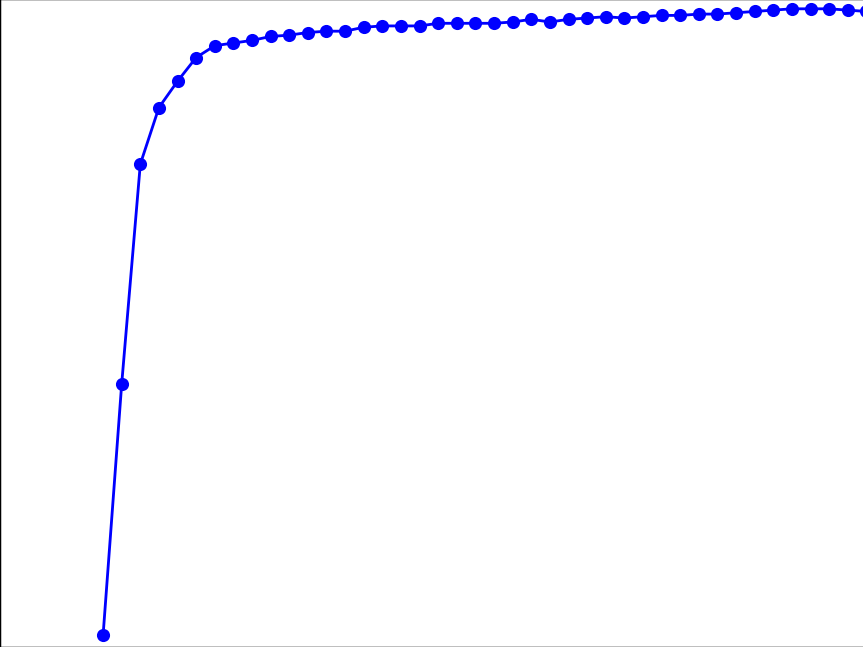

Text(0, 0.5, 'Accuracy')

In [55]:
%matplotlib notebook
x=list(range(1,5001))
y=[i * 100 for i in accuracies]
fig=plt.figure()
# plt.plot(x, y, marker='o', color = 'blue')
ax=fig.add_axes([0,0,1,1])
ax.plot(x, y, '-ok', color = 'blue')
ax.set_title("Accuracy progression through 50 Epochs")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

In [4]:
print(tf.__version__)

2.0.0
